#Setup

In [ ]:
 !curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
 !unzip -qq captcha_images_v2.zip && rm -rf captcha_images_v2.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   159  100   159    0     0    347      0 --:--:-- --:--:-- --:--:--   346
100 8863k  100 8863k    0     0  8697k      0  0:00:01  0:00:01 --:--:-- 8697k


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import functional as F


import numpy as np

from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


import albumentations as A


%matplotlib inline
import matplotlib.pyplot as plt

from glob import glob
from tqdm.notebook import tqdm

In [ ]:
dataset_path = '/content/captcha_images_v2'
imgs_paths = glob(dataset_path + "/*.png")
imgs_paths

batch_size = 16
img_width = 200
img_height = 50

num_workers = 2
epochs = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset

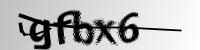

In [ ]:
Image.open(imgs_paths[0])

In [ ]:
aug = A.Compose(
        [ A.Normalize(always_apply=True),
         ]
    )
aug(image=np.array(Image.open(imgs_paths[0]).convert('RGB')))

{'image': array([[[1.1700487, 1.3256302, 1.5419607],
         [1.1700487, 1.3256302, 1.5419607],
         [1.1700487, 1.3256302, 1.5419607],
         ...,
         [2.1804092, 2.3585434, 2.5702832],
         [2.1804092, 2.3585434, 2.5702832],
         [2.1804092, 2.3585434, 2.5702832]],
 
        [[1.1700487, 1.3256302, 1.5419607],
         [1.1700487, 1.3256302, 1.5419607],
         [1.1700487, 1.3256302, 1.5419607],
         ...,
         [2.1804092, 2.3585434, 2.5702832],
         [2.1804092, 2.3585434, 2.5702832],
         [2.1804092, 2.3585434, 2.5702832]],
 
        [[1.1700487, 1.3256302, 1.5419607],
         [1.1700487, 1.3256302, 1.5419607],
         [1.1700487, 1.3256302, 1.5419607],
         ...,
         [2.1804092, 2.3585434, 2.5702832],
         [2.1804092, 2.3585434, 2.5702832],
         [2.1804092, 2.3585434, 2.5702832]],
 
        ...,
 
        [[1.221423 , 1.3781512, 1.5942483],
         [1.221423 , 1.3781512, 1.5942483],
         [1.221423 , 1.3781512, 1.5942483],
 

In [ ]:
class OCR_dataset:
  def __init__(self, imgs_path, labels, img_width,img_height):
    self.imgs_path = imgs_path
    self.labels = labels
    self.img_width = img_width
    self.img_height = img_height


    self.aug = A.Compose(
        [ A.Normalize(always_apply=True),
         ]
    )

  def __len__(self):
    return len(self.imgs_path)

  def __getitem__(self, idx):
    labels = self.labels[idx]
    img = Image.open(self.imgs_path[idx])
    img = img.convert('RGB')
    img = img.resize((self.img_width, self.img_height), resample=Image.BILINEAR)
    img = np.array(img)
    augmented_img = self.aug(image=img)
    img = augmented_img["image"]
    img = np.transpose(img, (2,0,1)).astype(np.float32)
    
    return {"images": torch.tensor(img, dtype=torch.float),
            "labels": torch.tensor(labels, dtype=torch.long)}



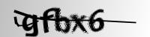
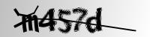
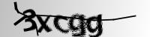
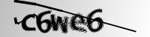
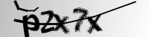
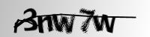
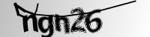
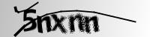
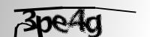
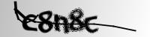
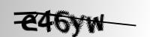
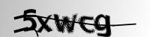
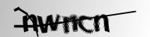
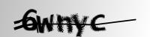
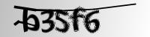
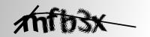
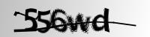
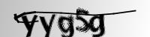
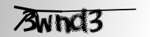
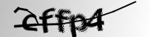
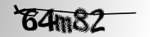
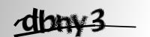
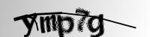
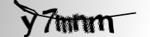
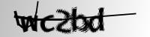
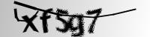
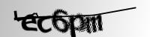
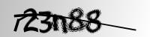
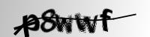
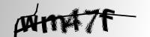


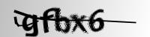
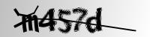
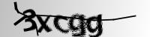
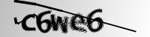
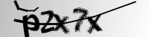
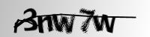
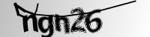
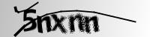
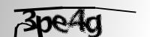
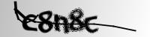
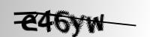
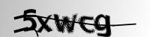
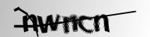
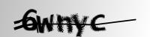
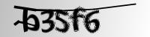
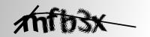
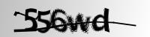
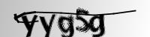
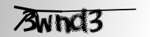
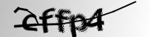
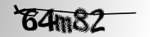
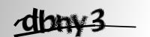
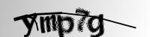
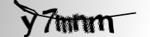
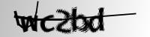
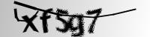
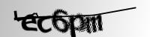
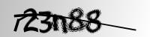
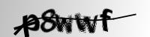
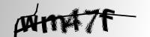

In [ ]:
#!pip install ipyplot
from ipyplot import plot_images
from glob import glob
plot_images(glob(dataset_path+'/*.png'),force_b64=True)

In [ ]:
# x44n4
labels_orig = [i.split("/")[-1].split(".")[0] for i in imgs_paths]
# ['x', '4', '4', 'n', '4']
labels = [[i for i in x] for x in labels_orig]
print(labels[0])

labels_flat = [i for sublist in labels for i in sublist]
labels_flat[0]

['g', 'f', 'b', 'x', '6']


'g'

In [ ]:
# label encoding  gives numbers:  ['x', '4', '4', 'n', '4'] --> array([17,  2,  2, 14,  2])
from sklearn import preprocessing
labels_enc = preprocessing.LabelEncoder()
labels_enc.fit(labels_flat)
# get classes similar with np.unique
print(labels_enc.classes_)
print(len(labels_enc.classes_))
lbls_enc = [labels_enc.transform(x) for x in labels]
# increment by 1 because we need to use 0 for unknown 
lbls_enc = np.array(lbls_enc) + 1

lbls_enc[:10]


['2' '3' '4' '5' '6' '7' '8' 'b' 'c' 'd' 'e' 'f' 'g' 'm' 'n' 'p' 'w' 'x'
 'y']
19


array([[13, 12,  8, 18,  5],
       [14,  3,  4,  6, 10],
       [ 2, 18,  9, 13, 13],
       [ 9,  5, 17, 11,  5],
       [16,  1, 18,  6, 18],
       [ 2, 15, 17,  6, 17],
       [15, 13, 15,  1,  5],
       [ 4, 15, 18, 15, 15],
       [ 2, 16, 11,  3, 13],
       [ 9,  7, 15,  7,  9]])

In [ ]:
# get uniqie values
np.unique(labels_flat)
# or
# get classes
print(labels_enc.classes_)

['2' '3' '4' '5' '6' '7' '8' 'b' 'c' 'd' 'e' 'f' 'g' 'm' 'n' 'p' 'w' 'x'
 'y']


In [ ]:
# split the data
from sklearn.model_selection import train_test_split
(train_imgs,
val_imgs,
train_labels,
val_labels,
train_orig_labels,
val_orig_labels) = train_test_split(imgs_paths, lbls_enc, labels_orig, test_size=0.1)

In [ ]:
print("train_imgs: ", train_imgs[0])
print("val_imgs: ", val_imgs[0])
print("train_labels: ", train_labels[0],)
print("val_labels: ", val_labels[0],)
print("train_orig_labels: ", train_orig_labels[0],)
print("val_orig_labels: ", val_orig_labels[0])

train_imgs:  /content/captcha_images_v2/264m5.png
val_imgs:  /content/captcha_images_v2/f75cx.png
train_labels:  [ 1  5  3 14  4]
val_labels:  [12  6  4  9 18]
train_orig_labels:  264m5
val_orig_labels:  f75cx


In [ ]:
# init dataset and dataloader
train_dataset = OCR_dataset(imgs_path=train_imgs, labels=train_labels, img_width=img_width, img_height=img_height)
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

In [ ]:
# init dataset and dataloader
val_dataset = OCR_dataset(imgs_path=val_imgs, labels=val_labels, img_width=img_width, img_height=img_height)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

In [ ]:
batch = iter(train_loader).next()
batch['images'][0]

tensor([[[1.1700, 1.1700, 1.1700,  ..., 2.1804, 2.1804, 2.1804],
         [1.1700, 1.1700, 1.1700,  ..., 2.1804, 2.1804, 2.1804],
         [1.1700, 1.1700, 1.1700,  ..., 2.1804, 2.1804, 2.1804],
         ...,
         [1.2214, 1.2214, 1.2214,  ..., 2.2318, 2.2318, 2.2318],
         [1.2214, 1.2214, 1.2214,  ..., 2.2318, 2.2318, 2.2318],
         [1.2214, 1.2214, 1.2214,  ..., 2.2318, 2.2318, 2.2318]],

        [[1.3256, 1.3256, 1.3256,  ..., 2.3585, 2.3585, 2.3585],
         [1.3256, 1.3256, 1.3256,  ..., 2.3585, 2.3585, 2.3585],
         [1.3256, 1.3256, 1.3256,  ..., 2.3585, 2.3585, 2.3585],
         ...,
         [1.3782, 1.3782, 1.3782,  ..., 2.4111, 2.4111, 2.4111],
         [1.3782, 1.3782, 1.3782,  ..., 2.4111, 2.4111, 2.4111],
         [1.3782, 1.3782, 1.3782,  ..., 2.4111, 2.4111, 2.4111]],

        [[1.5420, 1.5420, 1.5420,  ..., 2.5703, 2.5703, 2.5703],
         [1.5420, 1.5420, 1.5420,  ..., 2.5703, 2.5703, 2.5703],
         [1.5420, 1.5420, 1.5420,  ..., 2.5703, 2.5703, 2.

In [ ]:
test_img = batch['images'][0].numpy()
test_img.shape
test_img = np.transpose(test_img, (1,2,0))
# should be (75, 300, 3)
test_img.shape

(50, 200, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


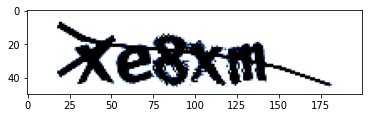

In [ ]:
plt.imshow(test_img)

# Model

In [ ]:

class OCR_Model(nn.Module):
  def __init__(self, num_characters):
    super().__init__()
    self.conv1 = nn.Conv2d(3,512,kernel_size=(3,3), padding=(1,1))
    self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2))

    self.conv2 = nn.Conv2d(512,256,kernel_size=(2,2), padding=(1,1))
    self.maxpool2 = nn.MaxPool2d(kernel_size=(1,1))

    self.conv3 = nn.Conv2d(256, 64, kernel_size=(1, 1), padding=(0,0))
    self.maxpool3 = nn.MaxPool2d(kernel_size=(1,1)) 

    self.linear1 = nn.Linear(1664,1664//2)
    self.linear2 =nn.Linear(1664//2, 1664//8)
    self.linear3 = nn.Linear(1664//8, 1664//16)
    self.linear4 = nn.Linear(1664//16, 64)

    self.gru = nn.GRU(64, 32, bidirectional=True,
                      num_layers=2,
                      dropout=0.2,
                      batch_first=True)
    self.output = nn.Linear(64, num_characters + 1)


  def forward(self, images, labels):
    bs, channels, height, width = images.size()
    # print(bs, channels, height, width)


    x = F.relu(self.conv1(images))
    # print(x.size())
    x = self.maxpool1(x)
    # print(x.size())
    x = F.relu(self.conv2(x))
    # print(x.size())
    x = self.maxpool2(x)
    # print(x.size())
    x = F.relu(self.conv3(x))
    # print(x.size())
    x = self.maxpool3(x)
    # print(x.size())

    # have to swap channels  and rnn : bs, c, h, w --> bs, w, c, h
    x = x.permute(0,3,1,2)
    # print(x.size())
    # flattening for linear layer
    x = x.view(bs, x.size(1), -1)
    # print(x.size()[2])

    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = F.relu(self.linear3(x))
    x = F.relu(self.linear4(x))

    x, _ = self.gru(x)
    # print(x.size())

    x = self.output(x)
    # print(x.size())

    x = x.permute(1,0,2)
    # print(x.size())

    log_softmax_values = F.log_softmax(x,2)

    input_lenghts = torch.full(size=(bs,),fill_value=log_softmax_values.size(0),
                               dtype = torch.int32)
    

    output_lenghts = torch.full(size=(bs,),fill_value=labels.size(1),
                               dtype = torch.int32)
    


    loss = nn.CTCLoss(blank=0)(
        log_softmax_values,
        labels,
        input_lenghts,
        output_lenghts)


    

    return x, loss



model = OCR_Model(num_characters=19)
model.to(device)

img = torch.rand(5,3,img_height,img_width).to(device)
label = torch.randint(1,20,(5,5,)).to(device)

preds = model(img,label)
print(preds)
  


    





(tensor([[[-6.3193e-03, -4.3473e-02, -8.5187e-02,  ...,  3.0844e-02,
           1.1257e-01, -3.9802e-02],
         [-1.8407e-02, -4.5056e-02, -7.3782e-02,  ..., -5.2689e-04,
           1.0113e-01, -6.0038e-02],
         [-1.1939e-02, -5.6140e-02, -4.3084e-02,  ...,  4.5467e-02,
           9.5416e-02, -5.9703e-02],
         [-1.4282e-02, -3.0914e-02, -7.2208e-02,  ...,  2.8276e-02,
           9.8922e-02, -2.8011e-02],
         [-2.1158e-02, -1.4500e-02, -5.9945e-02,  ...,  1.4013e-03,
           1.0757e-01, -3.8978e-02]],

        [[ 1.7849e-02, -2.6483e-02, -9.5483e-02,  ...,  4.1173e-02,
           1.0776e-01, -3.9383e-02],
         [-5.1961e-03, -1.1255e-02, -7.7369e-02,  ...,  1.2728e-02,
           9.1686e-02, -7.9375e-02],
         [-1.0510e-03, -3.9235e-02, -5.1163e-02,  ...,  4.5721e-02,
           7.2873e-02, -8.8338e-02],
         [ 2.8190e-03, -4.7356e-03, -7.9384e-02,  ...,  3.2307e-02,
           6.6251e-02, -2.4081e-02],
         [-8.5272e-03,  6.1281e-05, -6.4616e-02,  ..

# Train

In [ ]:
def decode_preds(preds, encoder):
    preds = preds.permute(1,0,2)
    preds = torch.softmax(preds,2)
    preds = torch.argmax(preds,2)
    preds = preds.detach().cpu().numpy()
    preds_list  = []
    for i in range(preds.shape[0]):
        tmp = []
        for j in preds[i,:]:
            j = j-1
            if j == -1:
                tmp.append("*")
            else:
                tmp.append(encoder.inverse_transform([j])[0])
        element = "".join(tmp)
        preds_list.append(element)
    return preds_list

In [ ]:
# criterion = torch.nn.CrossEntropyLoss()
lr = 3e-4
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=3,verbose=True)

In [ ]:
from tqdm.notebook import tqdm
train_losses = []
val_losses = []
for epoch in tqdm(range(200),'Epoch'):

  # train loop
  epoch_loss_train = 0
  final_preds = []
  model.train()
  
  tqdm_loop = tqdm(enumerate(train_loader),'Step', total=len(train_loader))
  for i,data in tqdm_loop:
    imgs = data['images'].to(device)
    labels = data['labels'].to(device)

    optimizer.zero_grad()    
    preds, loss = model(imgs,labels)
    
    loss.backward()
    optimizer.step()
    

    epoch_loss_train += loss.item() 
    epoch_loss_t = epoch_loss_train / len(train_loader)
    final_preds.append(preds)
    
    tqdm_loop.set_postfix(loss=loss.item())
  train_losses.append(epoch_loss_t)
  print(f'Train loss: {epoch_loss_t:9.4f}')
  
  # val loop
  with torch.no_grad():
    epoch_loss_val = 0
    final_preds = []
 
    model.eval()
    tqdm_loop = tqdm(enumerate(val_loader),'Step', total=len(val_loader))
    for i,data in tqdm_loop:
      imgs = data['images'].to(device)
      labels = data['labels'].to(device)
      preds, loss = model(imgs,labels)

      epoch_loss_val += loss.item() 
      epoch_loss_v = epoch_loss_val / len(val_loader)
      
      decoded_preds = decode_preds(preds, encoder=labels_enc)
      final_preds.extend(decoded_preds)

      tqdm_loop.set_postfix(loss=loss.item())
  scheduler.step(epoch_loss_v) #scheduler
  val_losses.append(epoch_loss_v)

  print("Epoch:",epoch)
  print(f'Val loss: {epoch_loss_v:9.4f}')
  print("final_preds: ", final_preds[0])
  print("test_orig_labels: ", val_orig_labels[0])
  






Train loss:   22.2924



Epoch: 0
Val loss:    5.8292
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    4.3416



Epoch: 1
Val loss:    3.4851
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    3.4148



Epoch: 2
Val loss:    3.3114
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    3.3059



Epoch: 3
Val loss:    3.2908
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    3.2806



Epoch: 4
Val loss:    3.2827
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    3.2726



Epoch: 5
Val loss:    3.2810
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    3.2684



Epoch: 6
Val loss:    3.2808
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    3.2678



Epoch: 7
Val loss:    3.2829
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    3.2663



Epoch: 8
Val loss:    3.2837
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    3.2670



Epoch    10: reducing learning rate of group 0 to 2.4000e-04.
Epoch: 9
Val loss:    3.2811
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    3.2666



Epoch: 10
Val loss:    3.2839
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    3.2663



Epoch: 11
Val loss:    3.2817
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    3.2663



Epoch: 12
Val loss:    3.2815
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    3.2665



Epoch: 13
Val loss:    3.2775
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    3.2659



Epoch: 14
Val loss:    3.2839
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    3.2665



Epoch: 15
Val loss:    3.2853
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    3.2659



Epoch: 16
Val loss:    3.2834
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    3.2656



Epoch    18: reducing learning rate of group 0 to 1.9200e-04.
Epoch: 17
Val loss:    3.2858
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    3.2650



Epoch: 18
Val loss:    3.2765
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    3.2618



Epoch: 19
Val loss:    3.2804
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    3.2581



Epoch: 20
Val loss:    3.2694
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    3.2536



Epoch: 21
Val loss:    3.2686
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    3.2478



Epoch: 22
Val loss:    3.2673
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    3.2384



Epoch: 23
Val loss:    3.2515
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    3.2269



Epoch: 24
Val loss:    3.2321
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    3.2115



Epoch: 25
Val loss:    3.2157
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    3.1899



Epoch: 26
Val loss:    3.2024
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    3.1572



Epoch: 27
Val loss:    3.1686
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    3.1235



Epoch: 28
Val loss:    3.1283
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    3.0839



Epoch: 29
Val loss:    3.0863
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    3.0391



Epoch: 30
Val loss:    3.0417
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    2.9878



Epoch: 31
Val loss:    2.9966
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    2.9313



Epoch: 32
Val loss:    2.9279
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    2.8623



Epoch: 33
Val loss:    2.8657
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    2.7843



Epoch: 34
Val loss:    2.7923
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    2.6995



Epoch: 35
Val loss:    2.6698
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    2.5858



Epoch: 36
Val loss:    2.5313
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    2.4602



Epoch: 37
Val loss:    2.3794
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    2.3023



Epoch: 38
Val loss:    2.2130
final_preds:  *****************************************************************************************************
test_orig_labels:  f75cx



Train loss:    2.1273



Epoch: 39
Val loss:    1.9945
final_preds:  ****************************d************pp********gg************************************************
test_orig_labels:  f75cx



Train loss:    1.9365



Epoch: 40
Val loss:    1.7876
final_preds:  *****************************************b*********gg*********d**************************************
test_orig_labels:  f75cx



Train loss:    1.7525



Epoch: 41
Val loss:    1.6375
final_preds:  **************************************************yy*************************************************
test_orig_labels:  f75cx



Train loss:    1.5682



Epoch: 42
Val loss:    1.4160
final_preds:  ***************************************************y************b************************************
test_orig_labels:  f75cx



Train loss:    1.3993



Epoch: 43
Val loss:    1.2482
final_preds:  *****************22**********************************************************************************
test_orig_labels:  f75cx



Train loss:    1.2471



Epoch: 44
Val loss:    1.1031
final_preds:  ********************c********7*********gg**********bb************************************************
test_orig_labels:  f75cx



Train loss:    1.1058



Epoch: 45
Val loss:    0.9606
final_preds:  ********************ccccx*****c*******************************5**************************************
test_orig_labels:  f75cx



Train loss:    0.9705



Epoch: 46
Val loss:    0.8316
final_preds:  *******************************b*******22*********66*********7***************************************
test_orig_labels:  f75cx



Train loss:    0.8449



Epoch: 47
Val loss:    0.7168
final_preds:  ************************x*****3**********88**********f***********************************************
test_orig_labels:  f75cx



Train loss:    0.7430



Epoch: 48
Val loss:    0.6378
final_preds:  ********************************e***************22**********5****************************************
test_orig_labels:  f75cx



Train loss:    0.6580



Epoch: 49
Val loss:    0.5636
final_preds:  *******************66************f*****22*********yy***********c*************************************
test_orig_labels:  f75cx



Train loss:    0.5943



Epoch: 50
Val loss:    0.5046
final_preds:  *******************ff*******cc********66*************x********b**************************************
test_orig_labels:  f75cx



Train loss:    0.5253



Epoch: 51
Val loss:    0.4398
final_preds:  ******************44*******************3********************nn***************************************
test_orig_labels:  f75cx



Train loss:    0.4861



Epoch: 52
Val loss:    0.4067
final_preds:  ******************55*********5********yy*********2*********n*****************************************
test_orig_labels:  f75cx



Train loss:    0.4440



Epoch: 53
Val loss:    0.4296
final_preds:  *****************22***********44*********5********yy**********5**************************************
test_orig_labels:  f75cx



Train loss:    0.4024



Epoch: 54
Val loss:    0.3506
final_preds:  *******************gg***********e********cc******n*************f*************************************
test_orig_labels:  f75cx



Train loss:    0.3742



Epoch: 55
Val loss:    0.3385
final_preds:  *******************6***********ff******ggg*********88**********cc************************************
test_orig_labels:  f75cx



Train loss:    0.3479



Epoch: 56
Val loss:    0.3106
final_preds:  ******************n************b*******22*********66*********7***************************************
test_orig_labels:  f75cx



Train loss:    0.3312



Epoch: 57
Val loss:    0.3054
final_preds:  ******************n****************44**********gg**********8**********gg*****************************
test_orig_labels:  f75cx



Train loss:    0.2932



Epoch: 58
Val loss:    0.2733
final_preds:  ******************55********55********yy*********2*********n*****************************************
test_orig_labels:  f75cx



Train loss:    0.2743



Epoch: 59
Val loss:    0.2812
final_preds:  *******************yy************f******22*********8**********d**************************************
test_orig_labels:  f75cx



Train loss:    0.2617



Epoch: 60
Val loss:    0.2604
final_preds:  ***********y*******44**********44**********f*******yy***********b************************************
test_orig_labels:  f75cx



Train loss:    0.2832



Epoch: 61
Val loss:    0.2561
final_preds:  *******************55*******n********n***n********6***********d**************************************
test_orig_labels:  f75cx



Train loss:    0.2432



Epoch: 62
Val loss:    0.2331
final_preds:  *******************c*e************x******yy***********c********n*************************************
test_orig_labels:  f75cx



Train loss:    0.2196



Epoch: 63
Val loss:    0.2391
final_preds:  ******************n************b*******22*********6**********7***************************************
test_orig_labels:  f75cx



Train loss:    0.2276



Epoch: 64
Val loss:    0.2255
final_preds:  ********************b***********bb********yy********m************yy**********************************
test_orig_labels:  f75cx



Train loss:    0.2056



Epoch: 65
Val loss:    0.2329
final_preds:  *******************8**********cc******m***********44**********66*************************************
test_orig_labels:  f75cx



Train loss:    0.1979



Epoch: 66
Val loss:    0.1948
final_preds:  ***********************xx******7*********77********44**********66************************************
test_orig_labels:  f75cx



Train loss:    0.1865



Epoch: 67
Val loss:    0.2311
final_preds:  *********************ee*******7**************x******44*********55************************************
test_orig_labels:  f75cx



Train loss:    0.2140



Epoch: 68
Val loss:    0.2025
final_preds:  *******************6**********n***************55***********e*******gg********************************
test_orig_labels:  f75cx



Train loss:    0.1799



Epoch: 69
Val loss:    0.1849
final_preds:  *******************ff*******dd***********pp********gg**********d*************************************
test_orig_labels:  f75cx



Train loss:    0.1645



Epoch: 70
Val loss:    0.1761
final_preds:  *******************6***********d**********d********22*********yy*************************************
test_orig_labels:  f75cx



Train loss:    0.1624



Epoch: 71
Val loss:    0.2027
final_preds:  *******************yy*********3********22**********yy**********yy************************************
test_orig_labels:  f75cx



Train loss:    0.1552



Epoch: 72
Val loss:    0.1555
final_preds:  ******************************bb**********p*******3************e*************************************
test_orig_labels:  f75cx



Train loss:    0.1451



Epoch: 73
Val loss:    0.1551
final_preds:  *******************ff*******d************p*********gg**********d*************************************
test_orig_labels:  f75cx



Train loss:    0.1439



Epoch: 74
Val loss:    0.1690
final_preds:  *******************4*********n***************22*********w******w*******55****************************
test_orig_labels:  f75cx



Train loss:    0.1577



Epoch: 75
Val loss:    0.2077
final_preds:  *******************gg***********e********cc******m*************f*************************************
test_orig_labels:  f75cx



Train loss:    0.1370



Epoch: 76
Val loss:    0.1795
final_preds:  ********************b*********yy*********55********yy*********33*************************************
test_orig_labels:  f75cx



Train loss:    0.1410



Epoch    78: reducing learning rate of group 0 to 1.5360e-04.
Epoch: 77
Val loss:    0.2538
final_preds:  **************************w**********************e*******66********m*********************************
test_orig_labels:  f75cx



Train loss:    0.1253



Epoch: 78
Val loss:    0.1603
final_preds:  *******************6*************f*****22*********yy***********c*************************************
test_orig_labels:  f75cx



Train loss:    0.1182



Epoch: 79
Val loss:    0.1467
final_preds:  *************************ww**********b*******************cc***************w**************************
test_orig_labels:  f75cx



Train loss:    0.1155



Epoch: 80
Val loss:    0.1575
final_preds:  ********************pp*******22*************x*******7*************x**********************************
test_orig_labels:  f75cx



Train loss:    0.1133



Epoch: 81
Val loss:    0.1478
final_preds:  *******************d*********m************w*****w*********88********n********************************
test_orig_labels:  f75cx



Train loss:    0.1086



Epoch: 82
Val loss:    0.1692
final_preds:  **************************y*******m************7********44**********6********************************
test_orig_labels:  f75cx



Train loss:    0.1087



Epoch    84: reducing learning rate of group 0 to 1.2288e-04.
Epoch: 83
Val loss:    0.1529
final_preds:  ********************b***********bb********yy********m************yy**********************************
test_orig_labels:  f75cx



Train loss:    0.0998



Epoch: 84
Val loss:    0.1966
final_preds:  *******************yy**********88**********6**********6**********yy**********************************
test_orig_labels:  f75cx



Train loss:    0.0997



Epoch: 85
Val loss:    0.1478
final_preds:  *******************yy************ff*****22*********8**********d**************************************
test_orig_labels:  f75cx



Train loss:    0.0997



Epoch: 86
Val loss:    0.1823
final_preds:  ******************n*********33********n*****************6**************x*****************************
test_orig_labels:  f75cx



Train loss:    0.0922



Epoch    88: reducing learning rate of group 0 to 9.8304e-05.
Epoch: 87
Val loss:    0.1699
final_preds:  *****************22*********n**************x*****3**********88***************************************
test_orig_labels:  f75cx



Train loss:    0.0899



Epoch: 88
Val loss:    0.1714
final_preds:  ********************f*******yy***********f********b********n*****************************************
test_orig_labels:  f75cx



Train loss:    0.0853



Epoch: 89
Val loss:    0.1547
final_preds:  *******************6***********p***************w**********c********n*********************************
test_orig_labels:  f75cx



Train loss:    0.0860



Epoch: 90
Val loss:    0.1986
final_preds:  ********************bb********w****************55********************ff******************************
test_orig_labels:  f75cx



Train loss:    0.0872



Epoch    92: reducing learning rate of group 0 to 7.8643e-05.
Epoch: 91
Val loss:    0.1578
final_preds:  *******************8**************x*********e********ff*******7**************************************
test_orig_labels:  f75cx



Train loss:    0.0805



Epoch: 92
Val loss:    0.1592
final_preds:  ********************f*******dd***********p*********gg**********d*************************************
test_orig_labels:  f75cx



Train loss:    0.0751



Epoch: 93
Val loss:    0.1640
final_preds:  *******************yy************f******22*********8**********d**************************************
test_orig_labels:  f75cx



Train loss:    0.0766



Epoch: 94
Val loss:    0.1724
final_preds:  ************************x*****3**********88**********ff******n***************************************
test_orig_labels:  f75cx



Train loss:    0.0705



Epoch    96: reducing learning rate of group 0 to 6.2915e-05.
Epoch: 95
Val loss:    0.1687
final_preds:  *****************************yy**********88********n************pp***********************************
test_orig_labels:  f75cx



Train loss:    0.0687



Epoch: 96
Val loss:    0.1633
final_preds:  ********************c*********ff*******pp*********8**********66**************************************
test_orig_labels:  f75cx



Train loss:    0.0668



Epoch: 97
Val loss:    0.1481
final_preds:  *******************gg********n**********yy***********6***********b***********************************
test_orig_labels:  f75cx



Train loss:    0.0669



Epoch: 98
Val loss:    0.1577
final_preds:  *****************************yy**********88********n************pp***********************************
test_orig_labels:  f75cx



Train loss:    0.0632



Epoch   100: reducing learning rate of group 0 to 5.0332e-05.
Epoch: 99
Val loss:    0.1659
final_preds:  *******************7*********6*******33**********5*******3*******************************************
test_orig_labels:  f75cx



Train loss:    0.0594



Epoch: 100
Val loss:    0.1567
final_preds:  ********************p**********g*******222********yy***************x*********************************
test_orig_labels:  f75cx



Train loss:    0.0584



Epoch: 101
Val loss:    0.1410
final_preds:  *******************yy**********88**********6**********6**********yy**********************************
test_orig_labels:  f75cx



Train loss:    0.0548



Epoch: 102
Val loss:    0.1527
final_preds:  *****************m*************d**********d*********gg**********bb***********************************
test_orig_labels:  f75cx



Train loss:    0.0558



Epoch: 103
Val loss:    0.1574
final_preds:  ************************x*****n***********ff***********x*****55**************************************
test_orig_labels:  f75cx



Train loss:    0.0545



Epoch: 104
Val loss:    0.1643
final_preds:  *******************d*********m************w*****w*********88********n********************************
test_orig_labels:  f75cx



Train loss:    0.0532



Epoch   106: reducing learning rate of group 0 to 4.0265e-05.
Epoch: 105
Val loss:    0.1479
final_preds:  *******************7*********7*******n***********6**********g****************************************
test_orig_labels:  f75cx



Train loss:    0.0517



Epoch: 106
Val loss:    0.1452
final_preds:  ********************p*********7***********f*******yy***********p*************************************
test_orig_labels:  f75cx



Train loss:    0.0500



Epoch: 107
Val loss:    0.1587
final_preds:  ******************************gg**********c********gg***********b************************************
test_orig_labels:  f75cx



Train loss:    0.0469



Epoch: 108
Val loss:    0.1797
final_preds:  *****************3***********8********n**********5*********7*****************************************
test_orig_labels:  f75cx



Train loss:    0.0466



Epoch   110: reducing learning rate of group 0 to 3.2212e-05.
Epoch: 109
Val loss:    0.1544
final_preds:  *******************6*************e********c**********b********n**************************************
test_orig_labels:  f75cx



Train loss:    0.0456



Epoch: 110
Val loss:    0.1650
final_preds:  ******************55********55********yy*********2*********n*****************************************
test_orig_labels:  f75cx



Train loss:    0.0432



Epoch: 111
Val loss:    0.1703
final_preds:  *****************22********55*******22********55*********7*******************************************
test_orig_labels:  f75cx



Train loss:    0.0432



Epoch: 112
Val loss:    0.1472
final_preds:  *****************w**************6**********yy*********n************ee********************************
test_orig_labels:  f75cx



Train loss:    0.0404



Epoch   114: reducing learning rate of group 0 to 2.5770e-05.
Epoch: 113
Val loss:    0.1520
final_preds:  ********************f*******d************p*********gg**********d*************************************
test_orig_labels:  f75cx



Train loss:    0.0425



Epoch: 114
Val loss:    0.1493
final_preds:  ******************n************ee*****3*********22*********55****************************************
test_orig_labels:  f75cx



Train loss:    0.0406



Epoch: 115
Val loss:    0.1661
final_preds:  *******************yy**********yy**********88********2**********4************************************
test_orig_labels:  f75cx



Train loss:    0.0393



Epoch: 116
Val loss:    0.1489
final_preds:  ******************************bb**********p*******3************e*************************************
test_orig_labels:  f75cx



Train loss:    0.0383



Epoch   118: reducing learning rate of group 0 to 2.0616e-05.
Epoch: 117
Val loss:    0.1501
final_preds:  *****************22***********44*********55*******yy**********55*************************************
test_orig_labels:  f75cx



Train loss:    0.0382



Epoch: 118
Val loss:    0.1513
final_preds:  *****************33***********b***********ff******n**********dd**************************************
test_orig_labels:  f75cx



Train loss:    0.0374



Epoch: 119
Val loss:    0.1466
final_preds:  *****************m*************d**********d*********gg**********bb***********************************
test_orig_labels:  f75cx



Train loss:    0.0367



Epoch: 120
Val loss:    0.1658
final_preds:  **************************w**********************e*******66********n*********************************
test_orig_labels:  f75cx



Train loss:    0.0371



Epoch   122: reducing learning rate of group 0 to 1.6493e-05.
Epoch: 121
Val loss:    0.1450
final_preds:  ******************n*********33********m*****************6**************x*****************************
test_orig_labels:  f75cx



Train loss:    0.0362



Epoch: 122
Val loss:    0.1495
final_preds:  *******************7*********6*******33**********5*******3*******************************************
test_orig_labels:  f75cx



Train loss:    0.0351



Epoch: 123
Val loss:    0.1466
final_preds:  *******************d*********m************w*****w*********88********n********************************
test_orig_labels:  f75cx



Train loss:    0.0339



Epoch: 124
Val loss:    0.1600
final_preds:  ******************n*********33********n*****************6**************x*****************************
test_orig_labels:  f75cx



Train loss:    0.0333



Epoch   126: reducing learning rate of group 0 to 1.3194e-05.
Epoch: 125
Val loss:    0.1504
final_preds:  *****************3***********8********n**********5*********7*****************************************
test_orig_labels:  f75cx



Train loss:    0.0338



Epoch: 126
Val loss:    0.1563
final_preds:  *******************6*************e********c**********b********n**************************************
test_orig_labels:  f75cx



Train loss:    0.0335



Epoch: 127
Val loss:    0.1491
final_preds:  ********************c*********6*********7*********44*********55**************************************
test_orig_labels:  f75cx



Train loss:    0.0339



Epoch: 128
Val loss:    0.1484
final_preds:  ******************n************e********gg*********gg*********n**************************************
test_orig_labels:  f75cx



Train loss:    0.0323



Epoch   130: reducing learning rate of group 0 to 1.0555e-05.
Epoch: 129
Val loss:    0.1541
final_preds:  ******************55*********d**************x******n********m****************************************
test_orig_labels:  f75cx



Train loss:    0.0328



Epoch: 130
Val loss:    0.1502
final_preds:  ******************3********22*********5************f********b****************************************
test_orig_labels:  f75cx



Train loss:    0.0316



Epoch: 131
Val loss:    0.1453
final_preds:  ********************f*******c*********6**************x********bb*************************************
test_orig_labels:  f75cx



Train loss:    0.0334



Epoch: 132
Val loss:    0.1566
final_preds:  *******************6********55*********8**************x********e*************************************
test_orig_labels:  f75cx



Train loss:    0.0304



Epoch   134: reducing learning rate of group 0 to 8.4442e-06.
Epoch: 133
Val loss:    0.1459
final_preds:  ******************55*********6*********m*****************6*********yy********************************
test_orig_labels:  f75cx



Train loss:    0.0319



Epoch: 134
Val loss:    0.1572
final_preds:  ********************cc**c*****c********88*********44*********55**************************************
test_orig_labels:  f75cx



Train loss:    0.0299



Epoch: 135
Val loss:    0.1500
final_preds:  *******************d*********22********22************b**********d************************************
test_orig_labels:  f75cx



Train loss:    0.0309



Epoch: 136
Val loss:    0.1503
final_preds:  *****************227*********44***********p***********e*****w****************************************
test_orig_labels:  f75cx



Train loss:    0.0303



Epoch   138: reducing learning rate of group 0 to 6.7554e-06.
Epoch: 137
Val loss:    0.1532
final_preds:  ******************555*******n************m********6***********d**************************************
test_orig_labels:  f75cx



Train loss:    0.0303



Epoch: 138
Val loss:    0.1518
final_preds:  ********************c*********6*********7*********44*********55**************************************
test_orig_labels:  f75cx



Train loss:    0.0303



Epoch: 139
Val loss:    0.1437
final_preds:  *************************wy*******m************7********44**********6********************************
test_orig_labels:  f75cx



Train loss:    0.0300



Epoch: 140
Val loss:    0.1479
final_preds:  ************************x*****n***********ff***********x*****55**************************************
test_orig_labels:  f75cx



Train loss:    0.0291



Epoch   142: reducing learning rate of group 0 to 5.4043e-06.
Epoch: 141
Val loss:    0.1444
final_preds:  ************************x*****3**********66*******22***********g*************************************
test_orig_labels:  f75cx



Train loss:    0.0292



Epoch: 142
Val loss:    0.1469
final_preds:  *******************gg***********e********cc******m*************f*************************************
test_orig_labels:  f75cx



Train loss:    0.0299



Epoch: 143
Val loss:    0.1719
final_preds:  *******************d*********22********22************b**********d************************************
test_orig_labels:  f75cx



Train loss:    0.0300



Epoch: 144
Val loss:    0.1536
final_preds:  *****************************yy**********88********n************pp***********************************
test_orig_labels:  f75cx



Train loss:    0.0298



Epoch   146: reducing learning rate of group 0 to 4.3235e-06.
Epoch: 145
Val loss:    0.1496
final_preds:  ******************44*********n*********3********m***********n****************************************
test_orig_labels:  f75cx



Train loss:    0.0280



Epoch: 146
Val loss:    0.1475
final_preds:  ********************b***********bb********yy********m************yy**********************************
test_orig_labels:  f75cx



Train loss:    0.0293



Epoch: 147
Val loss:    0.1443
final_preds:  *****************22*********n**************x*****3**********88***************************************
test_orig_labels:  f75cx



Train loss:    0.0280



Epoch: 148
Val loss:    0.1449
final_preds:  *****************222*********8********33**********44**********8**************************************
test_orig_labels:  f75cx



Train loss:    0.0275



Epoch   150: reducing learning rate of group 0 to 3.4588e-06.
Epoch: 149
Val loss:    0.1455
final_preds:  *******************44**********44**********f*******yy***********b************************************
test_orig_labels:  f75cx



Train loss:    0.0288



Epoch: 150
Val loss:    0.1474
final_preds:  ******************55*********6*********m*****************6*********yy********************************
test_orig_labels:  f75cx



Train loss:    0.0282



Epoch: 151
Val loss:    0.1465
final_preds:  *******************88**********cc********cc*******cc*********c***************************************
test_orig_labels:  f75cx



Train loss:    0.0283



Epoch: 152
Val loss:    0.1476
final_preds:  ********************f********4*************ww********f******n****************************************
test_orig_labels:  f75cx



Train loss:    0.0279



Epoch   154: reducing learning rate of group 0 to 2.7670e-06.
Epoch: 153
Val loss:    0.1608
final_preds:  *******************6*************f*****22*********yy***********c*************************************
test_orig_labels:  f75cx



Train loss:    0.0281



Epoch: 154
Val loss:    0.1455
final_preds:  *******************c*********44**********b*********gg**********d*************************************
test_orig_labels:  f75cx



Train loss:    0.0283



Epoch: 155
Val loss:    0.1418
final_preds:  *****************m*************d**********d*********gg**********bb***********************************
test_orig_labels:  f75cx



Train loss:    0.0272



Epoch: 156
Val loss:    0.1478
final_preds:  *******************8**********cc******m***********44**********66*************************************
test_orig_labels:  f75cx



Train loss:    0.0279



Epoch   158: reducing learning rate of group 0 to 2.2136e-06.
Epoch: 157
Val loss:    0.1485
final_preds:  *******************8**********8**********yy**********55******22**************************************
test_orig_labels:  f75cx



Train loss:    0.0280



Epoch: 158
Val loss:    0.1483
final_preds:  *******************8**********n********22***********p*********gg*************************************
test_orig_labels:  f75cx



Train loss:    0.0273



Epoch: 159
Val loss:    0.1545
final_preds:  ********************f*******d************p*********gg**********d*************************************
test_orig_labels:  f75cx



Train loss:    0.0274



Epoch: 160
Val loss:    0.1522
final_preds:  ********************f*******yy***********f********b********n*****************************************
test_orig_labels:  f75cx



Train loss:    0.0271



Epoch   162: reducing learning rate of group 0 to 1.7709e-06.
Epoch: 161
Val loss:    0.1422
final_preds:  ******************n************e********gg*********gg*********n**************************************
test_orig_labels:  f75cx



Train loss:    0.0289



Epoch: 162
Val loss:    0.1432
final_preds:  ********************f*******77********55*********c*************x*************************************
test_orig_labels:  f75cx



Train loss:    0.0273



Epoch: 163
Val loss:    0.1404
final_preds:  *****************33***********b***********ff******n**********dd**************************************
test_orig_labels:  f75cx



Train loss:    0.0278



Epoch: 164
Val loss:    0.1529
final_preds:  ********************b*********yy*********55********yy*********33*************************************
test_orig_labels:  f75cx



Train loss:    0.0275



Epoch: 165
Val loss:    0.1485
final_preds:  *******************d*********m************w*****w*********8*********n********************************
test_orig_labels:  f75cx



Train loss:    0.0269



Epoch: 166
Val loss:    0.1544
final_preds:  *******************6**********n***************55***********e*******gg********************************
test_orig_labels:  f75cx



Train loss:    0.0278



Epoch   168: reducing learning rate of group 0 to 1.4167e-06.
Epoch: 167
Val loss:    0.1486
final_preds:  ********************p********m*****************d********33****************w**************************
test_orig_labels:  f75cx



Train loss:    0.0266



Epoch: 168
Val loss:    0.1457
final_preds:  *******************yy************f******22*********8**********d**************************************
test_orig_labels:  f75cx



Train loss:    0.0271



Epoch: 169
Val loss:    0.1415
final_preds:  ********************p**********g*******222********yy***************x*********************************
test_orig_labels:  f75cx



Train loss:    0.0269



Epoch: 170
Val loss:    0.1755
final_preds:  *******************8**************x*********e********ff*******7**************************************
test_orig_labels:  f75cx



Train loss:    0.0268



Epoch   172: reducing learning rate of group 0 to 1.1334e-06.
Epoch: 171
Val loss:    0.1501
final_preds:  *******************gg*********77*********gg********n**********ff*************************************
test_orig_labels:  f75cx



Train loss:    0.0269



Epoch: 172
Val loss:    0.1530
final_preds:  ********************b*********4**********dd*********7**********c*************************************
test_orig_labels:  f75cx



Train loss:    0.0272



Epoch: 173
Val loss:    0.1437
final_preds:  *****************22***********44*********55*******yy**********55*************************************
test_orig_labels:  f75cx



Train loss:    0.0265



Epoch: 174
Val loss:    0.1692
final_preds:  ******************************gg**********c********gg***********b************************************
test_orig_labels:  f75cx



Train loss:    0.0263



Epoch   176: reducing learning rate of group 0 to 9.0669e-07.
Epoch: 175
Val loss:    0.1411
final_preds:  *******************yy*********3********22**********yy**********yy************************************
test_orig_labels:  f75cx



Train loss:    0.0265



Epoch: 176
Val loss:    0.1564
final_preds:  ******************44**********yy**********cc**********e************x*********************************
test_orig_labels:  f75cx



Train loss:    0.0262



Epoch: 177
Val loss:    0.1452
final_preds:  *******************gg**********d*********44********m***m**********f**********************************
test_orig_labels:  f75cx



Train loss:    0.0260



Epoch: 178
Val loss:    0.1623
final_preds:  *******************88**********cc********cc*******cc*********c***************************************
test_orig_labels:  f75cx



Train loss:    0.0259



Epoch   180: reducing learning rate of group 0 to 7.2536e-07.
Epoch: 179
Val loss:    0.1508
final_preds:  *****************3***********8********n**********5*********7*****************************************
test_orig_labels:  f75cx



Train loss:    0.0269



Epoch: 180
Val loss:    0.1498
final_preds:  ********************b*********yy*********55********yy*********33*************************************
test_orig_labels:  f75cx



Train loss:    0.0262



Epoch: 181
Val loss:    0.1476
final_preds:  **************************w********55*******22*********ff******n*************************************
test_orig_labels:  f75cx



Train loss:    0.0272



Epoch: 182
Val loss:    0.1462
final_preds:  *********************ee*******7**************x******44*********55************************************
test_orig_labels:  f75cx



Train loss:    0.0270



Epoch   184: reducing learning rate of group 0 to 5.8028e-07.
Epoch: 183
Val loss:    0.1530
final_preds:  ******************n*********33********m*****************6**************x*****************************
test_orig_labels:  f75cx



Train loss:    0.0264



Epoch: 184
Val loss:    0.1580
final_preds:  ********************c*********6*********7*********44*********55**************************************
test_orig_labels:  f75cx



Train loss:    0.0272



Epoch: 185
Val loss:    0.1401
final_preds:  *****************22*********n**************x*****3**********88***************************************
test_orig_labels:  f75cx



Train loss:    0.0262



Epoch: 186
Val loss:    0.1551
final_preds:  *******************d*********m************w*****w*********8*********n********************************
test_orig_labels:  f75cx



Train loss:    0.0270



Epoch: 187
Val loss:    0.1505
final_preds:  *******************yy***************x*******d*********7********m*************************************
test_orig_labels:  f75cx



Train loss:    0.0260



Epoch: 188
Val loss:    0.1560
final_preds:  *******************44**********44**********f*******yy***********b************************************
test_orig_labels:  f75cx



Train loss:    0.0262



Epoch   190: reducing learning rate of group 0 to 4.6423e-07.
Epoch: 189
Val loss:    0.1581
final_preds:  ************************x*****n***********ff***********x*****55**************************************
test_orig_labels:  f75cx



Train loss:    0.0272



Epoch: 190
Val loss:    0.1396
final_preds:  ********************b*********4**********dd*********7**********c*************************************
test_orig_labels:  f75cx



Train loss:    0.0265



Epoch: 191
Val loss:    0.1446
final_preds:  ******************55*********7*******3************b********n*****************************************
test_orig_labels:  f75cx



Train loss:    0.0266



Epoch: 192
Val loss:    0.1482
final_preds:  ******************3********22*********5************f********b****************************************
test_orig_labels:  f75cx



Train loss:    0.0262



Epoch: 193
Val loss:    0.1494
final_preds:  ********************p*********7***********f*******yy***********p*************************************
test_orig_labels:  f75cx



Train loss:    0.0260



Epoch   195: reducing learning rate of group 0 to 3.7138e-07.
Epoch: 194
Val loss:    0.1430
final_preds:  *******************7*********44***********e*******yy***********gg************************************
test_orig_labels:  f75cx



Train loss:    0.0260



Epoch: 195
Val loss:    0.1468
final_preds:  ******************n************ee*****3*********22*********55****************************************
test_orig_labels:  f75cx



Train loss:    0.0261



Epoch: 196
Val loss:    0.1411
final_preds:  *******************6*************e********c**********b********n**************************************
test_orig_labels:  f75cx



Train loss:    0.0261



Epoch: 197
Val loss:    0.1609
final_preds:  *******************yy*********3********22**********yy**********yy************************************
test_orig_labels:  f75cx



Train loss:    0.0256



Epoch   199: reducing learning rate of group 0 to 2.9711e-07.
Epoch: 198
Val loss:    0.1415
final_preds:  *****************3**********n**********d**************x******dd**************************************
test_orig_labels:  f75cx



Train loss:    0.0256



Epoch: 199
Val loss:    0.1459
final_preds:  ******************n**********gg*********44**********6************************************************
test_orig_labels:  f75cx



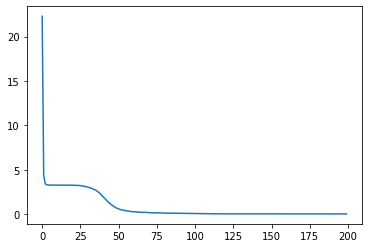

In [ ]:
plt.plot(range(len(train_losses)), train_losses)

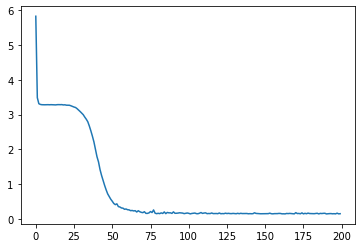

In [ ]:
plt.plot(range(len(val_losses)), val_losses)

# Note
ctc
https://distill.pub/2017/ctc/